In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.patches as patches

class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, action_dim)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

In [2]:
%matplotlib notebook

In [175]:
class HDQN:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.03):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        self.q_function_.load_state_dict(self.q_function.state_dict())
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 30000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state):
        q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, update_net = True):
        if(update_net):
            print('hard update')
            self.q_function_.load_state_dict(self.q_function.state_dict())
        self.memory.append([state, action, reward, int(done), next_state])
        #if(len(self.memory)>self.memory_lim):
            #self.memory = self.memory[len(self.memory)//2:]
            #print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease

In [5]:
env = gym.make('LunarLander-v2')

In [11]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

episode_n = 2000
t_max = 2000
do_clear = True

agent_h = HDQN(state_dim, action_dim,epsilon_decrease=0.1/episode_n)
hist_h = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_h.get_action([state])
        next_state, reward, done, _ = env.step(action[0])

        total_reward += reward
        agent_h.fit(state, int(action), reward, done, next_state,update_net=(t == 0 and episode%20==0))

        state = next_state

        if done:
            break
    
    hist_h.append(total_reward)
        
    if(np.mean(hist_h[-100:])>220):
        break

    print(f'episode: {episode}, total_reward_last_100: {np.mean(hist_h[-100:])} {hist_h[-1]}, epsilon: {agent_h.epsilon}')

hard update
episode: 0, total_reward_last_100: -70.9465100363722 -70.9465100363722, epsilon: 1
episode: 1, total_reward_last_100: -259.9488612396042 -448.95121244283615, epsilon: 0.9984500000000002
episode: 2, total_reward_last_100: -222.3352960486669 -147.10816566679233, epsilon: 0.9922500000000009
episode: 3, total_reward_last_100: -161.67550099827366 20.303884152905965, epsilon: 0.9883000000000013
episode: 4, total_reward_last_100: -176.70740715835285 -236.8350317986697, epsilon: 0.9829500000000019
episode: 5, total_reward_last_100: -154.05621999944245 -40.8002842048904, epsilon: 0.9762000000000026
episode: 6, total_reward_last_100: -176.37486717390462 -310.2867502206774, epsilon: 0.9717500000000031
episode: 7, total_reward_last_100: -173.65784134446085 -154.63866053835466, epsilon: 0.9662500000000037
episode: 8, total_reward_last_100: -163.4766776261389 -82.0273678795633, epsilon: 0.9626500000000041
episode: 9, total_reward_last_100: -160.53947600137727 -134.1046613785225, epsilon:

episode: 79, total_reward_last_100: -148.44149629313762 -193.32679290704436, epsilon: 0.5705500000000473
hard update
episode: 80, total_reward_last_100: -148.95660636250417 -190.1654119118303, epsilon: 0.5627000000000482
episode: 81, total_reward_last_100: -149.18356822064334 -167.56747872991326, epsilon: 0.5557000000000489
episode: 82, total_reward_last_100: -149.29721597315543 -158.6163316791476, epsilon: 0.5496500000000496
episode: 83, total_reward_last_100: -149.1111900493747 -133.6710383755753, epsilon: 0.5418000000000505
episode: 84, total_reward_last_100: -148.04270625399613 -58.29006744219621, epsilon: 0.5344000000000513
episode: 85, total_reward_last_100: -147.8175446258198 -128.67880623083153, epsilon: 0.527600000000052
episode: 86, total_reward_last_100: -150.07390551519535 -344.1209420014933, epsilon: 0.5218500000000527
episode: 87, total_reward_last_100: -148.28097484537045 7.7039934293967605, epsilon: 0.5171500000000532
episode: 88, total_reward_last_100: -149.39619789958

episode: 157, total_reward_last_100: -140.68833058024637 -124.43972058098036, epsilon: 0.02995000000010232
episode: 158, total_reward_last_100: -141.01486979076188 -85.29482708693445, epsilon: 0.02995000000010232
episode: 159, total_reward_last_100: -141.81419458455494 -104.467518973129, epsilon: 0.02995000000010232
hard update
episode: 160, total_reward_last_100: -143.73172206326961 -248.59916445491788, epsilon: 0.02995000000010232
episode: 161, total_reward_last_100: -143.9909890985659 -133.15548940559867, epsilon: 0.02995000000010232
episode: 162, total_reward_last_100: -145.03427483811677 -87.5828676817286, epsilon: 0.02995000000010232
episode: 163, total_reward_last_100: -144.39568439473933 -61.64926811211764, epsilon: 0.02995000000010232
episode: 164, total_reward_last_100: -143.36833935855836 -34.22824951427975, epsilon: 0.02995000000010232
episode: 165, total_reward_last_100: -143.89557996853583 -117.0076160155787, epsilon: 0.02995000000010232
episode: 166, total_reward_last_10

episode: 234, total_reward_last_100: -124.80586178650107 -92.8963366324189, epsilon: 0.02995000000010232
episode: 235, total_reward_last_100: -124.46485230211394 -85.62958853242803, epsilon: 0.02995000000010232
episode: 236, total_reward_last_100: -124.62425228641045 -113.74268491871925, epsilon: 0.02995000000010232
episode: 237, total_reward_last_100: -124.82397185185762 -125.3794626275228, epsilon: 0.02995000000010232
episode: 238, total_reward_last_100: -125.37342394855924 -165.09624747902913, epsilon: 0.02995000000010232
episode: 239, total_reward_last_100: -126.10945870741831 -177.71099901701584, epsilon: 0.02995000000010232
hard update
episode: 240, total_reward_last_100: -126.39457476801226 -89.77635084249553, epsilon: 0.02995000000010232
episode: 241, total_reward_last_100: -126.60680039259643 -149.54153187310123, epsilon: 0.02995000000010232
episode: 242, total_reward_last_100: -127.63660592215969 -139.14324079314247, epsilon: 0.02995000000010232
episode: 243, total_reward_las

episode: 311, total_reward_last_100: -139.88613192966662 -141.2501754977047, epsilon: 0.02995000000010232
episode: 312, total_reward_last_100: -139.18605868386555 -59.94517231740178, epsilon: 0.02995000000010232
episode: 313, total_reward_last_100: -138.7674666357431 -83.15261419138035, epsilon: 0.02995000000010232
episode: 314, total_reward_last_100: -141.1411938020134 -302.040458607349, epsilon: 0.02995000000010232
episode: 315, total_reward_last_100: -140.87464125337053 -140.14381237417638, epsilon: 0.02995000000010232
episode: 316, total_reward_last_100: -140.94482133825895 -158.761659063911, epsilon: 0.02995000000010232
episode: 317, total_reward_last_100: -143.17881637012616 -322.63705683464303, epsilon: 0.02995000000010232
episode: 318, total_reward_last_100: -142.79527704098157 -63.586379572639856, epsilon: 0.02995000000010232
episode: 319, total_reward_last_100: -143.4941019713537 -163.238568096408, epsilon: 0.02995000000010232
hard update
episode: 320, total_reward_last_100: 

episode: 388, total_reward_last_100: -133.52696840020647 -147.24554949107085, epsilon: 0.02995000000010232
episode: 389, total_reward_last_100: -133.59634176591914 -161.59107813504178, epsilon: 0.02995000000010232
episode: 390, total_reward_last_100: -134.00138389940608 -193.41714830251107, epsilon: 0.02995000000010232
episode: 391, total_reward_last_100: -135.5242911225061 -231.99559604434842, epsilon: 0.02995000000010232
episode: 392, total_reward_last_100: -134.45851349169791 -60.87609907277765, epsilon: 0.02995000000010232
episode: 393, total_reward_last_100: -134.4068550011259 -77.19742733850717, epsilon: 0.02995000000010232
episode: 394, total_reward_last_100: -134.87481981926032 -146.70570482956677, epsilon: 0.02995000000010232
episode: 395, total_reward_last_100: -135.16752304545847 -173.966614349965, epsilon: 0.02995000000010232
episode: 396, total_reward_last_100: -135.14370795086728 -138.6887001810146, epsilon: 0.02995000000010232
episode: 397, total_reward_last_100: -135.26

episode: 465, total_reward_last_100: -128.28648043761225 -47.30584444794744, epsilon: 0.02995000000010232
episode: 466, total_reward_last_100: -127.65457324590156 -49.36405220318562, epsilon: 0.02995000000010232
episode: 467, total_reward_last_100: -127.38976835041208 -104.86813570673105, epsilon: 0.02995000000010232
episode: 468, total_reward_last_100: -126.47806367230673 -79.70152772569821, epsilon: 0.02995000000010232
episode: 469, total_reward_last_100: -127.30914848884642 -176.8925388020137, epsilon: 0.02995000000010232
episode: 470, total_reward_last_100: -126.99615857723697 -104.15389619148591, epsilon: 0.02995000000010232
episode: 471, total_reward_last_100: -128.0571494516158 -207.04076354962223, epsilon: 0.02995000000010232
episode: 472, total_reward_last_100: -128.15331795347902 -105.85746195842547, epsilon: 0.02995000000010232
episode: 473, total_reward_last_100: -128.37813099013545 -109.88260279558601, epsilon: 0.02995000000010232
episode: 474, total_reward_last_100: -128.

episode: 542, total_reward_last_100: -90.99212666734189 -67.29968497574922, epsilon: 0.02995000000010232
episode: 543, total_reward_last_100: -90.59695218745604 -48.209450227656426, epsilon: 0.02995000000010232
episode: 544, total_reward_last_100: -90.46077730498206 -81.81733068820348, epsilon: 0.02995000000010232
episode: 545, total_reward_last_100: -88.03639689864887 -121.52297722261966, epsilon: 0.02995000000010232
episode: 546, total_reward_last_100: -87.6560868720872 -75.90519604029818, epsilon: 0.02995000000010232
episode: 547, total_reward_last_100: -88.04880369785182 -121.88147650632396, epsilon: 0.02995000000010232
episode: 548, total_reward_last_100: -86.3827405374733 -92.20097610227388, epsilon: 0.02995000000010232
episode: 549, total_reward_last_100: -85.96977835593977 -89.71566791679155, epsilon: 0.02995000000010232
episode: 550, total_reward_last_100: -89.26292822969343 -80.48741798840935, epsilon: 0.02995000000010232
episode: 551, total_reward_last_100: -89.1365306275506

episode: 620, total_reward_last_100: -86.23532895534808 -20.359151542443854, epsilon: 0.02995000000010232
episode: 621, total_reward_last_100: -86.87148073006988 -109.26619148924135, epsilon: 0.02995000000010232
episode: 622, total_reward_last_100: -87.42883067717277 -83.52803155988383, epsilon: 0.02995000000010232
episode: 623, total_reward_last_100: -90.76616370834654 -397.8085721631278, epsilon: 0.02995000000010232
episode: 624, total_reward_last_100: -89.46325083778777 23.14446862751143, epsilon: 0.02995000000010232
episode: 625, total_reward_last_100: -89.02095249716913 -124.76800735379682, epsilon: 0.02995000000010232
episode: 626, total_reward_last_100: -89.20448222070829 -44.886024938636744, epsilon: 0.02995000000010232
episode: 627, total_reward_last_100: -89.49186990089608 -68.4025737323499, epsilon: 0.02995000000010232
episode: 628, total_reward_last_100: -90.24183158111845 -168.0290674930291, epsilon: 0.02995000000010232
episode: 629, total_reward_last_100: -90.832322933391

episode: 698, total_reward_last_100: -137.30628969958047 -169.12655273811336, epsilon: 0.02995000000010232
episode: 699, total_reward_last_100: -137.4451638052934 -45.592263809507806, epsilon: 0.02995000000010232
hard update
episode: 700, total_reward_last_100: -138.9848907935102 -196.2817796251747, epsilon: 0.02995000000010232
episode: 701, total_reward_last_100: -138.83183482670424 -40.19937051150502, epsilon: 0.02995000000010232
episode: 702, total_reward_last_100: -140.12581892143336 -200.77793792409958, epsilon: 0.02995000000010232
episode: 703, total_reward_last_100: -140.4291660334681 -126.08077005069322, epsilon: 0.02995000000010232
episode: 704, total_reward_last_100: -140.59508739231777 -81.26719043298039, epsilon: 0.02995000000010232
episode: 705, total_reward_last_100: -143.14466908995067 -315.9021440805296, epsilon: 0.02995000000010232
episode: 706, total_reward_last_100: -142.5751165002813 -168.02798586380572, epsilon: 0.02995000000010232
episode: 707, total_reward_last_1

episode: 775, total_reward_last_100: -169.9944260806186 -114.96217341440794, epsilon: 0.02995000000010232
episode: 776, total_reward_last_100: -167.4641972800314 -56.91695225687374, epsilon: 0.02995000000010232
episode: 777, total_reward_last_100: -170.03344815367555 -324.76216340754127, epsilon: 0.02995000000010232
episode: 778, total_reward_last_100: -168.8521579715201 -9.761515783105812, epsilon: 0.02995000000010232
episode: 779, total_reward_last_100: -168.70049053211724 -161.12704800628023, epsilon: 0.02995000000010232
hard update
episode: 780, total_reward_last_100: -173.1377940281679 -523.9988966272863, epsilon: 0.02995000000010232
episode: 781, total_reward_last_100: -173.2700021851467 -133.55347097679788, epsilon: 0.02995000000010232
episode: 782, total_reward_last_100: -172.62625286823288 -54.677100451015036, epsilon: 0.02995000000010232
episode: 783, total_reward_last_100: -172.2359139808649 -80.20554680468045, epsilon: 0.02995000000010232
episode: 784, total_reward_last_100

episode: 852, total_reward_last_100: -159.3751086713085 -258.26968130256773, epsilon: 0.02995000000010232
episode: 853, total_reward_last_100: -158.74585908649104 -109.51778430063524, epsilon: 0.02995000000010232
episode: 854, total_reward_last_100: -157.28413719216778 -38.7469790474899, epsilon: 0.02995000000010232
episode: 855, total_reward_last_100: -156.05094920597222 -67.13684277966038, epsilon: 0.02995000000010232
episode: 856, total_reward_last_100: -156.82589286820485 -64.44711725899177, epsilon: 0.02995000000010232
episode: 857, total_reward_last_100: -154.22273404468456 -31.6721280098094, epsilon: 0.02995000000010232
episode: 858, total_reward_last_100: -154.50478342680947 -278.6142793317409, epsilon: 0.02995000000010232
episode: 859, total_reward_last_100: -153.89363143798371 -59.14233481664837, epsilon: 0.02995000000010232
hard update
episode: 860, total_reward_last_100: -153.23776008913998 -96.5075365914284, epsilon: 0.02995000000010232
episode: 861, total_reward_last_100:

episode: 930, total_reward_last_100: -85.75822928733197 123.38153839219234, epsilon: 0.02995000000010232
episode: 931, total_reward_last_100: -86.00408459144717 -129.5667114055188, epsilon: 0.02995000000010232
episode: 932, total_reward_last_100: -84.17423213037145 -15.569416756110911, epsilon: 0.02995000000010232
episode: 933, total_reward_last_100: -86.45276430727695 -293.34911425809787, epsilon: 0.02995000000010232
episode: 934, total_reward_last_100: -88.82721552010292 -319.83915296555745, epsilon: 0.02995000000010232
episode: 935, total_reward_last_100: -89.10607078140434 -45.50787910972471, epsilon: 0.02995000000010232
episode: 936, total_reward_last_100: -87.25330254815213 -136.61523730151794, epsilon: 0.02995000000010232
episode: 937, total_reward_last_100: -88.94814101365505 -264.5410153198064, epsilon: 0.02995000000010232
episode: 938, total_reward_last_100: -89.81505563217374 -208.63783145281747, epsilon: 0.02995000000010232
episode: 939, total_reward_last_100: -88.272418182

episode: 1008, total_reward_last_100: -68.88213102715098 -171.04843690874824, epsilon: 0.02995000000010232
episode: 1009, total_reward_last_100: -68.00006821309385 -175.91540788163258, epsilon: 0.02995000000010232
episode: 1010, total_reward_last_100: -66.52586073669352 -134.95233595724494, epsilon: 0.02995000000010232
episode: 1011, total_reward_last_100: -71.26868933327151 -265.1170258712708, epsilon: 0.02995000000010232
episode: 1012, total_reward_last_100: -68.51369415515279 205.5286904265003, epsilon: 0.02995000000010232
episode: 1013, total_reward_last_100: -72.04600306417029 -347.74675203559354, epsilon: 0.02995000000010232
episode: 1014, total_reward_last_100: -71.30419458315907 79.406519518279, epsilon: 0.02995000000010232
episode: 1015, total_reward_last_100: -68.57302753368909 -119.76809430421825, epsilon: 0.02995000000010232
episode: 1016, total_reward_last_100: -70.36728770926818 -244.09709030477805, epsilon: 0.02995000000010232
episode: 1017, total_reward_last_100: -66.57

episode: 1085, total_reward_last_100: -36.988877642372685 210.6600777927157, epsilon: 0.02995000000010232
episode: 1086, total_reward_last_100: -37.460146021585764 -117.47661177370341, epsilon: 0.02995000000010232
episode: 1087, total_reward_last_100: -38.836133333351775 -131.2828439844238, epsilon: 0.02995000000010232
episode: 1088, total_reward_last_100: -35.24896856311543 268.4339441083297, epsilon: 0.02995000000010232
episode: 1089, total_reward_last_100: -32.45252677070522 211.98224573631109, epsilon: 0.02995000000010232
episode: 1090, total_reward_last_100: -33.06471930308934 -162.69062284527854, epsilon: 0.02995000000010232
episode: 1091, total_reward_last_100: -30.922470952210677 180.3917187602911, epsilon: 0.02995000000010232
episode: 1092, total_reward_last_100: -30.455457861625504 16.93084709833279, epsilon: 0.02995000000010232
episode: 1093, total_reward_last_100: -27.621234930075158 192.53078313788077, epsilon: 0.02995000000010232
episode: 1094, total_reward_last_100: -23.

episode: 1162, total_reward_last_100: -28.90388081051994 -249.36435403902595, epsilon: 0.02995000000010232
episode: 1163, total_reward_last_100: -29.988036290278142 -135.45076427948794, epsilon: 0.02995000000010232
episode: 1164, total_reward_last_100: -32.98371847907091 -73.98531903712768, epsilon: 0.02995000000010232
episode: 1165, total_reward_last_100: -33.74704992211804 -111.71359960831917, epsilon: 0.02995000000010232
episode: 1166, total_reward_last_100: -34.00906027105789 212.0454309075218, epsilon: 0.02995000000010232
episode: 1167, total_reward_last_100: -34.50028282212801 -142.50089123677873, epsilon: 0.02995000000010232
episode: 1168, total_reward_last_100: -34.41265254931941 -34.71806719886817, epsilon: 0.02995000000010232
episode: 1169, total_reward_last_100: -30.605496085555757 287.7196130712804, epsilon: 0.02995000000010232
episode: 1170, total_reward_last_100: -27.723851536487373 -105.12282414251325, epsilon: 0.02995000000010232
episode: 1171, total_reward_last_100: -3

episode: 1239, total_reward_last_100: -15.613891169141443 189.39771804528732, epsilon: 0.02995000000010232
hard update
episode: 1240, total_reward_last_100: -14.858674296199453 -39.749433497758005, epsilon: 0.02995000000010232
episode: 1241, total_reward_last_100: -18.4178352452575 -155.51063225824151, epsilon: 0.02995000000010232
episode: 1242, total_reward_last_100: -14.489018719880002 224.20903365135678, epsilon: 0.02995000000010232
episode: 1243, total_reward_last_100: -15.361116209817174 -196.20351352782373, epsilon: 0.02995000000010232
episode: 1244, total_reward_last_100: -18.023125652010854 -25.381947149487388, epsilon: 0.02995000000010232
episode: 1245, total_reward_last_100: -20.574641738404736 -134.3532885726088, epsilon: 0.02995000000010232
episode: 1246, total_reward_last_100: -21.29210252384325 -98.2057198161701, epsilon: 0.02995000000010232
episode: 1247, total_reward_last_100: -17.83940944823117 243.43465777296004, epsilon: 0.02995000000010232
episode: 1248, total_rewar

episode: 1316, total_reward_last_100: 5.966786008211743 163.5944500790931, epsilon: 0.02995000000010232
episode: 1317, total_reward_last_100: 5.915787358252785 203.2736153255799, epsilon: 0.02995000000010232
episode: 1318, total_reward_last_100: 10.253111680196406 264.255456738948, epsilon: 0.02995000000010232
episode: 1319, total_reward_last_100: 7.700978779427297 -48.14115919002725, epsilon: 0.02995000000010232
hard update
episode: 1320, total_reward_last_100: 12.498980925910605 235.68838787757778, epsilon: 0.02995000000010232
episode: 1321, total_reward_last_100: 15.23159239624448 253.82356807054765, epsilon: 0.02995000000010232
episode: 1322, total_reward_last_100: 20.297912400349613 234.737948960451, epsilon: 0.02995000000010232
episode: 1323, total_reward_last_100: 17.561712141770926 -55.15247784552107, epsilon: 0.02995000000010232
episode: 1324, total_reward_last_100: 19.24537900352615 173.41147260986332, epsilon: 0.02995000000010232
episode: 1325, total_reward_last_100: 22.1823

episode: 1395, total_reward_last_100: 101.94265917238751 220.77237194911135, epsilon: 0.02995000000010232
episode: 1396, total_reward_last_100: 108.96200765462046 209.97640306459493, epsilon: 0.02995000000010232
episode: 1397, total_reward_last_100: 108.60980713786094 204.7885462128292, epsilon: 0.02995000000010232
episode: 1398, total_reward_last_100: 112.78928536738853 194.2769924035832, epsilon: 0.02995000000010232
episode: 1399, total_reward_last_100: 115.66281344922402 251.12517605490584, epsilon: 0.02995000000010232
hard update
episode: 1400, total_reward_last_100: 120.70349961122598 208.2363534443076, epsilon: 0.02995000000010232
episode: 1401, total_reward_last_100: 121.58458329807354 -115.24948926295252, epsilon: 0.02995000000010232
episode: 1402, total_reward_last_100: 122.06632328264868 217.1041355178618, epsilon: 0.02995000000010232
episode: 1403, total_reward_last_100: 122.66898431254107 240.4458190532776, epsilon: 0.02995000000010232
episode: 1404, total_reward_last_100: 

episode: 1473, total_reward_last_100: 72.02933404131639 -354.12931572321065, epsilon: 0.02995000000010232
episode: 1474, total_reward_last_100: 73.44901679879767 -3.586809803521362, epsilon: 0.02995000000010232
episode: 1475, total_reward_last_100: 72.71444003456747 108.13341789703591, epsilon: 0.02995000000010232
episode: 1476, total_reward_last_100: 69.31800280555562 -138.8261552479441, epsilon: 0.02995000000010232
episode: 1477, total_reward_last_100: 71.89080937635457 215.05795719052406, epsilon: 0.02995000000010232
episode: 1478, total_reward_last_100: 73.17532575119236 203.39968469450298, epsilon: 0.02995000000010232
episode: 1479, total_reward_last_100: 74.2819435966944 267.8394224442549, epsilon: 0.02995000000010232
hard update
episode: 1480, total_reward_last_100: 74.03396430558068 189.82388867961518, epsilon: 0.02995000000010232
episode: 1481, total_reward_last_100: 70.37263125932913 -126.50351456927694, epsilon: 0.02995000000010232
episode: 1482, total_reward_last_100: 70.37

episode: 1551, total_reward_last_100: 77.90824046415051 238.11288319283966, epsilon: 0.02995000000010232
episode: 1552, total_reward_last_100: 77.7968709844094 237.50256659901936, epsilon: 0.02995000000010232
episode: 1553, total_reward_last_100: 77.40824827338051 -25.434750018757995, epsilon: 0.02995000000010232
episode: 1554, total_reward_last_100: 76.71482933466467 195.60839193088754, epsilon: 0.02995000000010232
episode: 1555, total_reward_last_100: 76.8316973901988 281.63453555262197, epsilon: 0.02995000000010232
episode: 1556, total_reward_last_100: 80.91627867835919 189.12687181738295, epsilon: 0.02995000000010232
episode: 1557, total_reward_last_100: 76.15556671778754 -338.37338200623697, epsilon: 0.02995000000010232
episode: 1558, total_reward_last_100: 73.37213257936932 -7.497545428440461, epsilon: 0.02995000000010232
episode: 1559, total_reward_last_100: 73.13045305521933 218.6155859057851, epsilon: 0.02995000000010232
hard update
episode: 1560, total_reward_last_100: 73.078

episode: 1629, total_reward_last_100: 92.9935549391445 -252.39259123248723, epsilon: 0.02995000000010232
episode: 1630, total_reward_last_100: 91.8944321475412 -170.6172900372681, epsilon: 0.02995000000010232
episode: 1631, total_reward_last_100: 92.32604528484036 -70.70273106031999, epsilon: 0.02995000000010232
episode: 1632, total_reward_last_100: 87.8387553420211 -218.050414350629, epsilon: 0.02995000000010232
episode: 1633, total_reward_last_100: 88.46153162401033 -177.42502384181455, epsilon: 0.02995000000010232
episode: 1634, total_reward_last_100: 87.61676243608626 -166.41672122212668, epsilon: 0.02995000000010232
episode: 1635, total_reward_last_100: 91.41064899394684 229.68498484574806, epsilon: 0.02995000000010232
episode: 1636, total_reward_last_100: 88.49148472523775 -39.51701506117773, epsilon: 0.02995000000010232
episode: 1637, total_reward_last_100: 86.68417628312186 -27.438499268224945, epsilon: 0.02995000000010232
episode: 1638, total_reward_last_100: 86.14838948678484

episode: 1707, total_reward_last_100: -16.81541557715888 217.60895762958813, epsilon: 0.02995000000010232
episode: 1708, total_reward_last_100: -20.776580697512102 -142.7194131593803, epsilon: 0.02995000000010232
episode: 1709, total_reward_last_100: -22.53254864053783 15.326377038194735, epsilon: 0.02995000000010232
episode: 1710, total_reward_last_100: -23.238797765791606 -139.35136789516113, epsilon: 0.02995000000010232
episode: 1711, total_reward_last_100: -22.677391462584715 231.01532326116296, epsilon: 0.02995000000010232
episode: 1712, total_reward_last_100: -23.60814189941961 160.38396339863056, epsilon: 0.02995000000010232
episode: 1713, total_reward_last_100: -23.40036617741397 225.25873163778022, epsilon: 0.02995000000010232
episode: 1714, total_reward_last_100: -26.12230057063263 -106.83052816371911, epsilon: 0.02995000000010232
episode: 1715, total_reward_last_100: -21.59819696664551 123.65180460169782, epsilon: 0.02995000000010232
episode: 1716, total_reward_last_100: -22

episode: 1784, total_reward_last_100: -41.25331807643072 -115.62515130471922, epsilon: 0.02995000000010232
episode: 1785, total_reward_last_100: -44.02479482052352 -436.92469538054473, epsilon: 0.02995000000010232
episode: 1786, total_reward_last_100: -43.72120017957302 -66.04634400976019, epsilon: 0.02995000000010232
episode: 1787, total_reward_last_100: -43.95634660587945 -142.1074611887663, epsilon: 0.02995000000010232
episode: 1788, total_reward_last_100: -44.73654522562697 -168.40801659318748, epsilon: 0.02995000000010232
episode: 1789, total_reward_last_100: -45.77533363248255 -217.33314904149864, epsilon: 0.02995000000010232
episode: 1790, total_reward_last_100: -45.51852983907572 -84.5091944030286, epsilon: 0.02995000000010232
episode: 1791, total_reward_last_100: -47.79876369019487 -284.1737255401771, epsilon: 0.02995000000010232
episode: 1792, total_reward_last_100: -47.6345975153178 -160.16918281939348, epsilon: 0.02995000000010232
episode: 1793, total_reward_last_100: -48.2

episode: 1861, total_reward_last_100: -48.909013693246486 -88.98961383070758, epsilon: 0.02995000000010232
episode: 1862, total_reward_last_100: -50.39759739040719 -189.26923440641295, epsilon: 0.02995000000010232
episode: 1863, total_reward_last_100: -48.623220512170676 159.71592937340102, epsilon: 0.02995000000010232
episode: 1864, total_reward_last_100: -50.10916464901472 -221.38806410438093, epsilon: 0.02995000000010232
episode: 1865, total_reward_last_100: -46.276242152656074 211.92337968510228, epsilon: 0.02995000000010232
episode: 1866, total_reward_last_100: -41.35674989541387 210.8408961765076, epsilon: 0.02995000000010232
episode: 1867, total_reward_last_100: -44.75420341434644 -177.1114809858113, epsilon: 0.02995000000010232
episode: 1868, total_reward_last_100: -47.226222133982795 -64.05947754039568, epsilon: 0.02995000000010232
episode: 1869, total_reward_last_100: -48.328692791877565 -169.26286905904988, epsilon: 0.02995000000010232
episode: 1870, total_reward_last_100: -

episode: 1938, total_reward_last_100: 23.440805797767084 266.40304898539813, epsilon: 0.02995000000010232
episode: 1939, total_reward_last_100: 19.347897316589812 -154.71854793776492, epsilon: 0.02995000000010232
hard update
episode: 1940, total_reward_last_100: 18.836303161841215 -152.00069608056452, epsilon: 0.02995000000010232
episode: 1941, total_reward_last_100: 17.017037097096775 -120.69499862597951, epsilon: 0.02995000000010232
episode: 1942, total_reward_last_100: 15.11693950827111 -275.1606173134267, epsilon: 0.02995000000010232
episode: 1943, total_reward_last_100: 15.627870721367707 -115.79606141337877, epsilon: 0.02995000000010232
episode: 1944, total_reward_last_100: 15.298537908904963 -107.77072864610375, epsilon: 0.02995000000010232
episode: 1945, total_reward_last_100: 13.643270520551944 -221.69002092304186, epsilon: 0.02995000000010232
episode: 1946, total_reward_last_100: 14.04188434833326 125.56596845287298, epsilon: 0.02995000000010232
episode: 1947, total_reward_la

In [36]:
#env = gym.make('LunarLander-v2')
agent_h.epsilon = 0
total_reward = 0
state = env.reset()
for t in range(t_max):
    action = agent_h.get_action([state])
    next_state, reward, done, _ = env.step(action[0])
    env.render()
    total_reward += reward
    state = next_state
    if done:
        break
print(total_reward)

-165.60246600712213


In [6]:
env = gym.make('LunarLander-v2')

In [30]:
class SDQN:
    def __init__(self, state_dim, action_dim, gamma=0.993, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data*0)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 150000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target= False):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = self.memory[int(self.memory_lim*0.05):]
            self.memory = random.sample(self.memory, int(self.memory_lim*0.9))
            print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

episode_n = 2000
t_max = 1000
do_clear = True

agent_s = SDQN(state_dim, action_dim,epsilon_decrease=0.03/episode_n)
hist_s = []
hist_s_v = []
hist_s_v_disc = []
hist_s_v_ = []
hist_s_v_disc_ = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_s.get_action([state])
        next_state, reward, done, _ = env.step(action[0])

        total_reward += reward
        agent_s.fit(state, int(action), reward, done, next_state,tau = 0.005)

        state = next_state

        if done:
            break
    
    hist_s.append(total_reward)
    
    #validate
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], True)
            next_state, reward, done, _ = env.step(action[0])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v_.append(total_reward)
        hist_s_v_disc_.append(total_reward_disc)
        
    
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], False)
            next_state, reward, done, _ = env.step(action[0])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v.append(total_reward)
        hist_s_v_disc.append(total_reward_disc)
        
    if(np.mean(hist_s_v[-10:])>220):
        break

    print(f'episode: {episode}, \
rew: {round(np.mean(hist_s[-100:]),2)}, \
v_: {round(np.mean(hist_s_v_[-10:]),2)}, \
v_disc_: {round(np.mean(hist_s_v_disc_[-10:]),2)}, \
v: {round(np.mean(hist_s_v[-10:]),2)}, \
v_disc: {round(np.mean(hist_s_v_disc[-10:]),2)}, \
epsilon: {round(agent_s.epsilon,2)}, \
mem: {len(agent_s.memory)}')

episode: 0, rew: -120.49, v_: -132.61, v_disc_: -82.09, v: -1094.8, v_disc: -499.94, epsilon: 1, mem: 67
episode: 1, rew: -82.35, v_: -132.61, v_disc_: -82.09, v: -1094.8, v_disc: -499.94, epsilon: 1.0, mem: 131
episode: 2, rew: -101.29, v_: -132.61, v_disc_: -82.09, v: -1094.8, v_disc: -499.94, epsilon: 1.0, mem: 244
episode: 3, rew: -105.8, v_: -132.61, v_disc_: -82.09, v: -1094.8, v_disc: -499.94, epsilon: 1.0, mem: 327
episode: 4, rew: -98.74, v_: -132.61, v_disc_: -82.09, v: -1094.8, v_disc: -499.94, epsilon: 1.0, mem: 391
episode: 5, rew: -99.63, v_: -132.61, v_disc_: -82.09, v: -1094.8, v_disc: -499.94, epsilon: 0.99, mem: 475
episode: 6, rew: -114.89, v_: -132.61, v_disc_: -82.09, v: -1094.8, v_disc: -499.94, epsilon: 0.99, mem: 566
episode: 7, rew: -123.43, v_: -132.61, v_disc_: -82.09, v: -1094.8, v_disc: -499.94, epsilon: 0.99, mem: 649
episode: 8, rew: -115.0, v_: -132.61, v_disc_: -82.09, v: -1094.8, v_disc: -499.94, epsilon: 0.99, mem: 762
episode: 9, rew: -142.75, v_: -1

episode: 75, rew: -164.07, v_: -339.13, v_disc_: -177.62, v: -439.4, v_disc: -216.79, epsilon: 0.9, mem: 6720
episode: 76, rew: -163.46, v_: -339.13, v_disc_: -177.62, v: -439.4, v_disc: -216.79, epsilon: 0.9, mem: 6788
episode: 77, rew: -162.16, v_: -339.13, v_disc_: -177.62, v: -439.4, v_disc: -216.79, epsilon: 0.9, mem: 6911
episode: 78, rew: -161.52, v_: -339.13, v_disc_: -177.62, v: -439.4, v_disc: -216.79, epsilon: 0.9, mem: 6971
episode: 79, rew: -160.04, v_: -339.13, v_disc_: -177.62, v: -439.4, v_disc: -216.79, epsilon: 0.9, mem: 7048
episode: 80, rew: -159.85, v_: -347.74, v_disc_: -189.03, v: -467.66, v_disc: -241.07, epsilon: 0.89, mem: 7148
episode: 81, rew: -159.84, v_: -347.74, v_disc_: -189.03, v: -467.66, v_disc: -241.07, epsilon: 0.89, mem: 7259
episode: 82, rew: -159.52, v_: -347.74, v_disc_: -189.03, v: -467.66, v_disc: -241.07, epsilon: 0.89, mem: 7408
episode: 83, rew: -159.37, v_: -347.74, v_disc_: -189.03, v: -467.66, v_disc: -241.07, epsilon: 0.89, mem: 7543
ep

episode: 149, rew: -129.69, v_: -271.48, v_disc_: -153.31, v: -335.2, v_disc: -205.21, epsilon: 0.79, mem: 14093
episode: 150, rew: -128.92, v_: -271.96, v_disc_: -151.63, v: -307.13, v_disc: -185.87, epsilon: 0.79, mem: 14189
episode: 151, rew: -125.56, v_: -271.96, v_disc_: -151.63, v: -307.13, v_disc: -185.87, epsilon: 0.79, mem: 14269
episode: 152, rew: -126.01, v_: -271.96, v_disc_: -151.63, v: -307.13, v_disc: -185.87, epsilon: 0.79, mem: 14375
episode: 153, rew: -125.5, v_: -271.96, v_disc_: -151.63, v: -307.13, v_disc: -185.87, epsilon: 0.78, mem: 14501
episode: 154, rew: -126.98, v_: -271.96, v_disc_: -151.63, v: -307.13, v_disc: -185.87, epsilon: 0.78, mem: 14603
episode: 155, rew: -126.65, v_: -271.96, v_disc_: -151.63, v: -307.13, v_disc: -185.87, epsilon: 0.78, mem: 14684
episode: 156, rew: -126.77, v_: -271.96, v_disc_: -151.63, v: -307.13, v_disc: -185.87, epsilon: 0.78, mem: 14790
episode: 157, rew: -126.57, v_: -271.96, v_disc_: -151.63, v: -307.13, v_disc: -185.87, ep

episode: 223, rew: -101.57, v_: -172.61, v_disc_: -87.33, v: -198.71, v_disc: -76.63, epsilon: 0.68, mem: 21406
episode: 224, rew: -102.51, v_: -172.61, v_disc_: -87.33, v: -198.71, v_disc: -76.63, epsilon: 0.68, mem: 21463
episode: 225, rew: -99.29, v_: -172.61, v_disc_: -87.33, v: -198.71, v_disc: -76.63, epsilon: 0.68, mem: 21533
episode: 226, rew: -98.54, v_: -172.61, v_disc_: -87.33, v: -198.71, v_disc: -76.63, epsilon: 0.68, mem: 21622
episode: 227, rew: -98.11, v_: -172.61, v_disc_: -87.33, v: -198.71, v_disc: -76.63, epsilon: 0.68, mem: 21717
episode: 228, rew: -97.78, v_: -172.61, v_disc_: -87.33, v: -198.71, v_disc: -76.63, epsilon: 0.67, mem: 21804
episode: 229, rew: -96.78, v_: -172.61, v_disc_: -87.33, v: -198.71, v_disc: -76.63, epsilon: 0.67, mem: 21901
episode: 230, rew: -95.68, v_: -152.32, v_disc_: -68.26, v: -193.4, v_disc: -69.98, epsilon: 0.67, mem: 21973
episode: 231, rew: -95.4, v_: -152.32, v_disc_: -68.26, v: -193.4, v_disc: -69.98, epsilon: 0.67, mem: 22100
ep

episode: 298, rew: -89.84, v_: -140.39, v_disc_: -20.12, v: -254.52, v_disc: -45.88, epsilon: 0.52, mem: 31933
episode: 299, rew: -90.83, v_: -140.39, v_disc_: -20.12, v: -254.52, v_disc: -45.88, epsilon: 0.52, mem: 32068
episode: 300, rew: -90.95, v_: -179.88, v_disc_: -26.69, v: -248.32, v_disc: -35.7, epsilon: 0.52, mem: 32176
episode: 301, rew: -91.45, v_: -179.88, v_disc_: -26.69, v: -248.32, v_disc: -35.7, epsilon: 0.52, mem: 32374
episode: 302, rew: -91.21, v_: -179.88, v_disc_: -26.69, v: -248.32, v_disc: -35.7, epsilon: 0.52, mem: 32449
episode: 303, rew: -93.68, v_: -179.88, v_disc_: -26.69, v: -248.32, v_disc: -35.7, epsilon: 0.51, mem: 32617
episode: 304, rew: -94.15, v_: -179.88, v_disc_: -26.69, v: -248.32, v_disc: -35.7, epsilon: 0.51, mem: 32717
episode: 305, rew: -94.07, v_: -179.88, v_disc_: -26.69, v: -248.32, v_disc: -35.7, epsilon: 0.51, mem: 32893
episode: 306, rew: -94.77, v_: -179.88, v_disc_: -26.69, v: -248.32, v_disc: -35.7, epsilon: 0.51, mem: 33037
episode:

episode: 372, rew: -152.24, v_: -191.45, v_disc_: -17.52, v: -211.83, v_disc: -21.96, epsilon: 0.01, mem: 68877
episode: 373, rew: -152.39, v_: -191.45, v_disc_: -17.52, v: -211.83, v_disc: -21.96, epsilon: 0.01, mem: 69877
episode: 374, rew: -151.9, v_: -191.45, v_disc_: -17.52, v: -211.83, v_disc: -21.96, epsilon: 0.01, mem: 70877
episode: 375, rew: -148.8, v_: -191.45, v_disc_: -17.52, v: -211.83, v_disc: -21.96, epsilon: 0.01, mem: 71877
episode: 376, rew: -148.66, v_: -191.45, v_disc_: -17.52, v: -211.83, v_disc: -21.96, epsilon: 0.01, mem: 72877
episode: 377, rew: -148.29, v_: -191.45, v_disc_: -17.52, v: -211.83, v_disc: -21.96, epsilon: 0.01, mem: 73877
episode: 378, rew: -147.58, v_: -191.45, v_disc_: -17.52, v: -211.83, v_disc: -21.96, epsilon: 0.01, mem: 74877
episode: 379, rew: -146.07, v_: -191.45, v_disc_: -17.52, v: -211.83, v_disc: -21.96, epsilon: 0.01, mem: 75877
episode: 380, rew: -146.37, v_: -175.31, v_disc_: -14.67, v: -180.67, v_disc: -15.54, epsilon: 0.01, mem: 

episode: 447, rew: -138.29, v_: -133.33, v_disc_: 15.67, v: -102.84, v_disc: 22.71, epsilon: 0.01, mem: 130049
episode: 448, rew: -138.69, v_: -133.33, v_disc_: 15.67, v: -102.84, v_disc: 22.71, epsilon: 0.01, mem: 131049
episode: 449, rew: -138.75, v_: -133.33, v_disc_: 15.67, v: -102.84, v_disc: 22.71, epsilon: 0.01, mem: 132049
episode: 450, rew: -138.04, v_: -126.35, v_disc_: 14.16, v: -101.55, v_disc: 22.0, epsilon: 0.01, mem: 133049
episode: 451, rew: -137.16, v_: -126.35, v_disc_: 14.16, v: -101.55, v_disc: 22.0, epsilon: 0.01, mem: 133363
episode: 452, rew: -136.07, v_: -126.35, v_disc_: 14.16, v: -101.55, v_disc: 22.0, epsilon: 0.01, mem: 134363
episode: 453, rew: -135.74, v_: -126.35, v_disc_: 14.16, v: -101.55, v_disc: 22.0, epsilon: 0.01, mem: 135060
episode: 454, rew: -134.37, v_: -126.35, v_disc_: 14.16, v: -101.55, v_disc: 22.0, epsilon: 0.01, mem: 135385
episode: 455, rew: -134.79, v_: -126.35, v_disc_: 14.16, v: -101.55, v_disc: 22.0, epsilon: 0.01, mem: 136240
episode

episode: 522, rew: -153.92, v_: -105.44, v_disc_: 3.85, v: -157.12, v_disc: 17.0, epsilon: 0.01, mem: 140689
episode: 523, rew: -152.92, v_: -105.44, v_disc_: 3.85, v: -157.12, v_disc: 17.0, epsilon: 0.01, mem: 141112
episode: 524, rew: -152.56, v_: -105.44, v_disc_: 3.85, v: -157.12, v_disc: 17.0, epsilon: 0.01, mem: 142112
episode: 525, rew: -151.26, v_: -105.44, v_disc_: 3.85, v: -157.12, v_disc: 17.0, epsilon: 0.01, mem: 142436
episode: 526, rew: -148.98, v_: -105.44, v_disc_: 3.85, v: -157.12, v_disc: 17.0, epsilon: 0.01, mem: 142814
episode: 527, rew: -147.19, v_: -105.44, v_disc_: 3.85, v: -157.12, v_disc: 17.0, epsilon: 0.01, mem: 143814
episode: 528, rew: -148.27, v_: -105.44, v_disc_: 3.85, v: -157.12, v_disc: 17.0, epsilon: 0.01, mem: 144814
episode: 529, rew: -148.13, v_: -105.44, v_disc_: 3.85, v: -157.12, v_disc: 17.0, epsilon: 0.01, mem: 145256
episode: 530, rew: -145.47, v_: -75.94, v_disc_: 8.91, v: -148.01, v_disc: 20.5, epsilon: 0.01, mem: 146256
episode: 531, rew: -

episode: 598, rew: -37.73, v_: -31.12, v_disc_: 21.08, v: -31.78, v_disc: 18.7, epsilon: 0.01, mem: 148292
episode: 599, rew: -38.35, v_: -31.12, v_disc_: 21.08, v: -31.78, v_disc: 18.7, epsilon: 0.01, mem: 148644
episode: 600, rew: -37.33, v_: -22.2, v_disc_: 22.16, v: -5.13, v_disc: 25.56, epsilon: 0.01, mem: 149644
clear memory
episode: 601, rew: -35.56, v_: -22.2, v_disc_: 22.16, v: -5.13, v_disc: 25.56, epsilon: 0.01, mem: 135643
episode: 602, rew: -32.87, v_: -22.2, v_disc_: 22.16, v: -5.13, v_disc: 25.56, epsilon: 0.01, mem: 136643
episode: 603, rew: -30.68, v_: -22.2, v_disc_: 22.16, v: -5.13, v_disc: 25.56, epsilon: 0.01, mem: 137643
episode: 604, rew: -27.51, v_: -22.2, v_disc_: 22.16, v: -5.13, v_disc: 25.56, epsilon: 0.01, mem: 138643
episode: 605, rew: -28.31, v_: -22.2, v_disc_: 22.16, v: -5.13, v_disc: 25.56, epsilon: 0.01, mem: 138983
episode: 606, rew: -29.91, v_: -22.2, v_disc_: 22.16, v: -5.13, v_disc: 25.56, epsilon: 0.01, mem: 139983
episode: 607, rew: -28.43, v_: 

episode: 676, rew: 25.99, v_: -9.51, v_disc_: 38.88, v: 61.75, v_disc: 43.3, epsilon: 0.01, mem: 137067
episode: 677, rew: 26.34, v_: -9.51, v_disc_: 38.88, v: 61.75, v_disc: 43.3, epsilon: 0.01, mem: 137925
episode: 678, rew: 22.21, v_: -9.51, v_disc_: 38.88, v: 61.75, v_disc: 43.3, epsilon: 0.01, mem: 138800
episode: 679, rew: 24.03, v_: -9.51, v_disc_: 38.88, v: 61.75, v_disc: 43.3, epsilon: 0.01, mem: 139488
episode: 680, rew: 23.47, v_: -14.36, v_disc_: 35.42, v: 33.14, v_disc: 38.54, epsilon: 0.01, mem: 139984
episode: 681, rew: 23.44, v_: -14.36, v_disc_: 35.42, v: 33.14, v_disc: 38.54, epsilon: 0.01, mem: 140413
episode: 682, rew: 23.66, v_: -14.36, v_disc_: 35.42, v: 33.14, v_disc: 38.54, epsilon: 0.01, mem: 140889
episode: 683, rew: 22.65, v_: -14.36, v_disc_: 35.42, v: 33.14, v_disc: 38.54, epsilon: 0.01, mem: 141564
episode: 684, rew: 19.83, v_: -14.36, v_disc_: 35.42, v: 33.14, v_disc: 38.54, epsilon: 0.01, mem: 142024
episode: 685, rew: 19.55, v_: -14.36, v_disc_: 35.42, 

clear memory
episode: 754, rew: 151.08, v_: 112.07, v_disc_: 47.18, v: 108.37, v_disc: 51.53, epsilon: 0.01, mem: 135244
episode: 755, rew: 153.93, v_: 112.07, v_disc_: 47.18, v: 108.37, v_disc: 51.53, epsilon: 0.01, mem: 135857
episode: 756, rew: 154.25, v_: 112.07, v_disc_: 47.18, v: 108.37, v_disc: 51.53, epsilon: 0.01, mem: 136388
episode: 757, rew: 157.19, v_: 112.07, v_disc_: 47.18, v: 108.37, v_disc: 51.53, epsilon: 0.01, mem: 136670
episode: 758, rew: 157.42, v_: 112.07, v_disc_: 47.18, v: 108.37, v_disc: 51.53, epsilon: 0.01, mem: 137291
episode: 759, rew: 159.24, v_: 112.07, v_disc_: 47.18, v: 108.37, v_disc: 51.53, epsilon: 0.01, mem: 137597
episode: 760, rew: 160.18, v_: 147.12, v_disc_: 48.82, v: 115.21, v_disc: 48.66, epsilon: 0.01, mem: 138089
episode: 761, rew: 156.47, v_: 147.12, v_disc_: 48.82, v: 115.21, v_disc: 48.66, epsilon: 0.01, mem: 138576
episode: 762, rew: 158.77, v_: 147.12, v_disc_: 48.82, v: 115.21, v_disc: 48.66, epsilon: 0.01, mem: 138882
episode: 763, r

episode: 831, rew: 193.85, v_: 209.38, v_disc_: 51.03, v: 68.15, v_disc: 20.26, epsilon: 0.01, mem: 136057
episode: 832, rew: 193.02, v_: 209.38, v_disc_: 51.03, v: 68.15, v_disc: 20.26, epsilon: 0.01, mem: 136425
episode: 833, rew: 192.81, v_: 209.38, v_disc_: 51.03, v: 68.15, v_disc: 20.26, epsilon: 0.01, mem: 136811
episode: 834, rew: 190.07, v_: 209.38, v_disc_: 51.03, v: 68.15, v_disc: 20.26, epsilon: 0.01, mem: 136915
episode: 835, rew: 189.74, v_: 209.38, v_disc_: 51.03, v: 68.15, v_disc: 20.26, epsilon: 0.01, mem: 137768
episode: 836, rew: 187.58, v_: 209.38, v_disc_: 51.03, v: 68.15, v_disc: 20.26, epsilon: 0.01, mem: 137966
episode: 837, rew: 186.84, v_: 209.38, v_disc_: 51.03, v: 68.15, v_disc: 20.26, epsilon: 0.01, mem: 138334
episode: 838, rew: 183.95, v_: 209.38, v_disc_: 51.03, v: 68.15, v_disc: 20.26, epsilon: 0.01, mem: 138481
episode: 839, rew: 183.51, v_: 209.38, v_disc_: 51.03, v: 68.15, v_disc: 20.26, epsilon: 0.01, mem: 138982
episode: 840, rew: 182.98, v_: 205.36

episode: 908, rew: 155.61, v_: 217.58, v_disc_: 55.86, v: 29.41, v_disc: 4.17, epsilon: 0.01, mem: 139538
episode: 909, rew: 155.91, v_: 217.58, v_disc_: 55.86, v: 29.41, v_disc: 4.17, epsilon: 0.01, mem: 139934
episode: 910, rew: 155.77, v_: 221.35, v_disc_: 56.38, v: 57.71, v_disc: 15.83, epsilon: 0.01, mem: 140279
episode: 911, rew: 156.28, v_: 221.35, v_disc_: 56.38, v: 57.71, v_disc: 15.83, epsilon: 0.01, mem: 140729
episode: 912, rew: 155.68, v_: 221.35, v_disc_: 56.38, v: 57.71, v_disc: 15.83, epsilon: 0.01, mem: 141087
episode: 913, rew: 155.97, v_: 221.35, v_disc_: 56.38, v: 57.71, v_disc: 15.83, epsilon: 0.01, mem: 141728
episode: 914, rew: 154.65, v_: 221.35, v_disc_: 56.38, v: 57.71, v_disc: 15.83, epsilon: 0.01, mem: 141891
episode: 915, rew: 154.66, v_: 221.35, v_disc_: 56.38, v: 57.71, v_disc: 15.83, epsilon: 0.01, mem: 142248
episode: 916, rew: 155.23, v_: 221.35, v_disc_: 56.38, v: 57.71, v_disc: 15.83, epsilon: 0.01, mem: 142838
episode: 917, rew: 155.27, v_: 221.35, 

episode: 985, rew: 201.06, v_: 164.62, v_disc_: 58.47, v: 202.23, v_disc: 61.31, epsilon: 0.01, mem: 142306
episode: 986, rew: 198.34, v_: 164.62, v_disc_: 58.47, v: 202.23, v_disc: 61.31, epsilon: 0.01, mem: 142536
episode: 987, rew: 197.34, v_: 164.62, v_disc_: 58.47, v: 202.23, v_disc: 61.31, epsilon: 0.01, mem: 143038
episode: 988, rew: 196.81, v_: 164.62, v_disc_: 58.47, v: 202.23, v_disc: 61.31, epsilon: 0.01, mem: 143423
episode: 989, rew: 197.16, v_: 164.62, v_disc_: 58.47, v: 202.23, v_disc: 61.31, epsilon: 0.01, mem: 143759
episode: 990, rew: 199.64, v_: 166.71, v_disc_: 56.76, v: 202.81, v_disc: 60.63, epsilon: 0.01, mem: 144168
episode: 991, rew: 199.53, v_: 166.71, v_disc_: 56.76, v: 202.81, v_disc: 60.63, epsilon: 0.01, mem: 144645
episode: 992, rew: 199.24, v_: 166.71, v_disc_: 56.76, v: 202.81, v_disc: 60.63, epsilon: 0.01, mem: 144966
episode: 993, rew: 199.5, v_: 166.71, v_disc_: 56.76, v: 202.81, v_disc: 60.63, epsilon: 0.01, mem: 145277
episode: 994, rew: 200.25, v_

episode: 1061, rew: 229.26, v_: 256.89, v_disc_: 68.31, v: 159.89, v_disc: 50.21, epsilon: 0.01, mem: 141680
episode: 1062, rew: 229.02, v_: 256.89, v_disc_: 68.31, v: 159.89, v_disc: 50.21, epsilon: 0.01, mem: 141969
episode: 1063, rew: 228.93, v_: 256.89, v_disc_: 68.31, v: 159.89, v_disc: 50.21, epsilon: 0.01, mem: 142268
episode: 1064, rew: 228.99, v_: 256.89, v_disc_: 68.31, v: 159.89, v_disc: 50.21, epsilon: 0.01, mem: 142572
episode: 1065, rew: 228.55, v_: 256.89, v_disc_: 68.31, v: 159.89, v_disc: 50.21, epsilon: 0.01, mem: 142859
episode: 1066, rew: 229.34, v_: 256.89, v_disc_: 68.31, v: 159.89, v_disc: 50.21, epsilon: 0.01, mem: 143120
episode: 1067, rew: 228.23, v_: 256.89, v_disc_: 68.31, v: 159.89, v_disc: 50.21, epsilon: 0.01, mem: 143542
episode: 1068, rew: 227.75, v_: 256.89, v_disc_: 68.31, v: 159.89, v_disc: 50.21, epsilon: 0.01, mem: 144068
episode: 1069, rew: 227.37, v_: 256.89, v_disc_: 68.31, v: 159.89, v_disc: 50.21, epsilon: 0.01, mem: 144327
episode: 1070, rew:

episode: 1137, rew: 234.32, v_: 227.91, v_disc_: 76.19, v: 136.06, v_disc: 43.57, epsilon: 0.01, mem: 140342
episode: 1138, rew: 234.25, v_: 227.91, v_disc_: 76.19, v: 136.06, v_disc: 43.57, epsilon: 0.01, mem: 140760
episode: 1139, rew: 231.61, v_: 227.91, v_disc_: 76.19, v: 136.06, v_disc: 43.57, epsilon: 0.01, mem: 140876
episode: 1140, rew: 231.28, v_: 226.45, v_disc_: 76.75, v: 147.27, v_disc: 48.04, epsilon: 0.01, mem: 141194
episode: 1141, rew: 231.54, v_: 226.45, v_disc_: 76.75, v: 147.27, v_disc: 48.04, epsilon: 0.01, mem: 141539
episode: 1142, rew: 226.96, v_: 226.45, v_disc_: 76.75, v: 147.27, v_disc: 48.04, epsilon: 0.01, mem: 141671
episode: 1143, rew: 226.74, v_: 226.45, v_disc_: 76.75, v: 147.27, v_disc: 48.04, epsilon: 0.01, mem: 141934
episode: 1144, rew: 227.08, v_: 226.45, v_disc_: 76.75, v: 147.27, v_disc: 48.04, epsilon: 0.01, mem: 142232
episode: 1145, rew: 226.24, v_: 226.45, v_disc_: 76.75, v: 147.27, v_disc: 48.04, epsilon: 0.01, mem: 142511
episode: 1146, rew:

episode: 1213, rew: 202.5, v_: 233.45, v_disc_: 73.61, v: 213.41, v_disc: 55.49, epsilon: 0.01, mem: 138556
episode: 1214, rew: 202.24, v_: 233.45, v_disc_: 73.61, v: 213.41, v_disc: 55.49, epsilon: 0.01, mem: 138989
episode: 1215, rew: 202.09, v_: 233.45, v_disc_: 73.61, v: 213.41, v_disc: 55.49, epsilon: 0.01, mem: 139335
episode: 1216, rew: 202.39, v_: 233.45, v_disc_: 73.61, v: 213.41, v_disc: 55.49, epsilon: 0.01, mem: 139635
episode: 1217, rew: 202.12, v_: 233.45, v_disc_: 73.61, v: 213.41, v_disc: 55.49, epsilon: 0.01, mem: 140292
episode: 1218, rew: 201.7, v_: 233.45, v_disc_: 73.61, v: 213.41, v_disc: 55.49, epsilon: 0.01, mem: 140987
episode: 1219, rew: 201.65, v_: 233.45, v_disc_: 73.61, v: 213.41, v_disc: 55.49, epsilon: 0.01, mem: 141515
episode: 1220, rew: 201.73, v_: 234.45, v_disc_: 72.28, v: 215.71, v_disc: 56.54, epsilon: 0.01, mem: 141817
episode: 1221, rew: 202.43, v_: 234.45, v_disc_: 72.28, v: 215.71, v_disc: 56.54, epsilon: 0.01, mem: 142100
episode: 1222, rew: 2

episode: 1289, rew: 223.36, v_: 259.51, v_disc_: 73.04, v: 198.53, v_disc: 47.16, epsilon: 0.01, mem: 136523
episode: 1290, rew: 222.57, v_: 254.6, v_disc_: 72.25, v: 197.37, v_disc: 48.26, epsilon: 0.01, mem: 136972
episode: 1291, rew: 219.97, v_: 254.6, v_disc_: 72.25, v: 197.37, v_disc: 48.26, epsilon: 0.01, mem: 137134
episode: 1292, rew: 219.94, v_: 254.6, v_disc_: 72.25, v: 197.37, v_disc: 48.26, epsilon: 0.01, mem: 137487
episode: 1293, rew: 220.22, v_: 254.6, v_disc_: 72.25, v: 197.37, v_disc: 48.26, epsilon: 0.01, mem: 137706
episode: 1294, rew: 220.84, v_: 254.6, v_disc_: 72.25, v: 197.37, v_disc: 48.26, epsilon: 0.01, mem: 138095
episode: 1295, rew: 221.45, v_: 254.6, v_disc_: 72.25, v: 197.37, v_disc: 48.26, epsilon: 0.01, mem: 139033
episode: 1296, rew: 221.16, v_: 254.6, v_disc_: 72.25, v: 197.37, v_disc: 48.26, epsilon: 0.01, mem: 139402
episode: 1297, rew: 222.14, v_: 254.6, v_disc_: 72.25, v: 197.37, v_disc: 48.26, epsilon: 0.01, mem: 139761
episode: 1298, rew: 219.64,

episode: 1365, rew: 176.25, v_: 170.24, v_disc_: 54.68, v: 161.74, v_disc: 51.48, epsilon: 0.01, mem: 146674
episode: 1366, rew: 176.63, v_: 170.24, v_disc_: 54.68, v: 161.74, v_disc: 51.48, epsilon: 0.01, mem: 146933
episode: 1367, rew: 179.13, v_: 170.24, v_disc_: 54.68, v: 161.74, v_disc: 51.48, epsilon: 0.01, mem: 147184
episode: 1368, rew: 178.22, v_: 170.24, v_disc_: 54.68, v: 161.74, v_disc: 51.48, epsilon: 0.01, mem: 147699
episode: 1369, rew: 175.48, v_: 170.24, v_disc_: 54.68, v: 161.74, v_disc: 51.48, epsilon: 0.01, mem: 147806
episode: 1370, rew: 172.75, v_: 165.15, v_disc_: 52.54, v: 125.57, v_disc: 50.16, epsilon: 0.01, mem: 147932
episode: 1371, rew: 174.43, v_: 165.15, v_disc_: 52.54, v: 125.57, v_disc: 50.16, epsilon: 0.01, mem: 148384
episode: 1372, rew: 173.71, v_: 165.15, v_disc_: 52.54, v: 125.57, v_disc: 50.16, epsilon: 0.01, mem: 148789
episode: 1373, rew: 173.64, v_: 165.15, v_disc_: 52.54, v: 125.57, v_disc: 50.16, epsilon: 0.01, mem: 149005
episode: 1374, rew:

episode: 1441, rew: 126.21, v_: 140.74, v_disc_: 41.25, v: 180.71, v_disc: 61.68, epsilon: 0.01, mem: 144539
episode: 1442, rew: 125.91, v_: 140.74, v_disc_: 41.25, v: 180.71, v_disc: 61.68, epsilon: 0.01, mem: 144853
episode: 1443, rew: 129.66, v_: 140.74, v_disc_: 41.25, v: 180.71, v_disc: 61.68, epsilon: 0.01, mem: 145283
episode: 1444, rew: 129.33, v_: 140.74, v_disc_: 41.25, v: 180.71, v_disc: 61.68, epsilon: 0.01, mem: 145661
episode: 1445, rew: 128.63, v_: 140.74, v_disc_: 41.25, v: 180.71, v_disc: 61.68, epsilon: 0.01, mem: 146008
episode: 1446, rew: 127.42, v_: 140.74, v_disc_: 41.25, v: 180.71, v_disc: 61.68, epsilon: 0.01, mem: 146615
episode: 1447, rew: 126.75, v_: 140.74, v_disc_: 41.25, v: 180.71, v_disc: 61.68, epsilon: 0.01, mem: 147240
episode: 1448, rew: 129.73, v_: 140.74, v_disc_: 41.25, v: 180.71, v_disc: 61.68, epsilon: 0.01, mem: 148134
episode: 1449, rew: 127.21, v_: 140.74, v_disc_: 41.25, v: 180.71, v_disc: 61.68, epsilon: 0.01, mem: 149134
episode: 1450, rew:

<IPython.core.display.Javascript object>


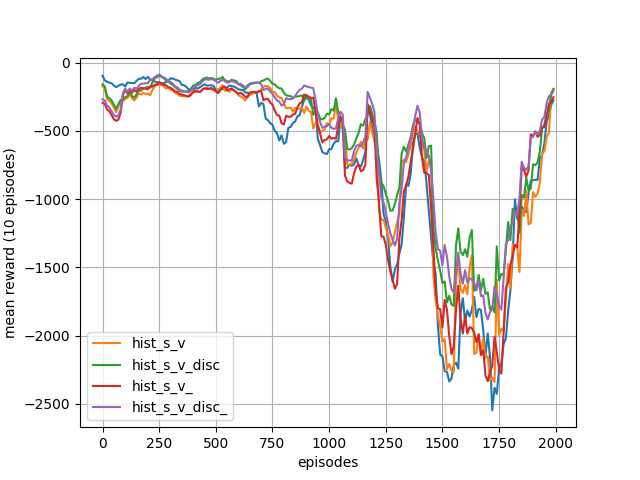

In [28]:
plt.grid(True)
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s[::10],np.ones(10)/10,mode='same'))
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v,np.ones(10)/10,mode='same'),label='hist_s_v')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc,np.ones(10)/10,mode='same'),label='hist_s_v_disc')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_,np.ones(10)/10,mode='same'),label='hist_s_v_')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc_,np.ones(10)/10,mode='same'),label='hist_s_v_disc_')
plt.xlabel('episodes')
plt.ylabel('mean reward (10 episodes)')
plt.legend()

In [29]:
plt.savefig('s_0.01e_0.005_false_128_0.03_0.999.png',dpi = 300, bbox_inches='tight', facecolor='w')

In [174]:
for target_param, local_param in zip(agent_s.q_function_.parameters(), agent_s.q_function.parameters()):
    print(torch.max((target_param-local_param)/target_param),torch.max((target_param-local_param)/local_param))

tensor(0.6526, grad_fn=<MaxBackward1>) tensor(1.8782, grad_fn=<MaxBackward1>)
tensor(0.1711, grad_fn=<MaxBackward1>) tensor(0.2064, grad_fn=<MaxBackward1>)
tensor(31.8134, grad_fn=<MaxBackward1>) tensor(1.5412, grad_fn=<MaxBackward1>)
tensor(0.2741, grad_fn=<MaxBackward1>) tensor(0.3776, grad_fn=<MaxBackward1>)
tensor(0.0166, grad_fn=<MaxBackward1>) tensor(0.0169, grad_fn=<MaxBackward1>)
tensor(-0.0004, grad_fn=<MaxBackward1>) tensor(-0.0004, grad_fn=<MaxBackward1>)


In [16]:
#env = gym.make('LunarLander-v2')
agent_s.epsilon = 0
total_reward = 0
state = env.reset()
for t in range(t_max):
    action = agent_s.get_action([state],True)
    next_state, reward, done, _ = env.step(action[0])
    env.render()
    total_reward += reward
    state = next_state
    if done:
        break
print(total_reward)

240.1724654514018


<IPython.core.display.Javascript object>


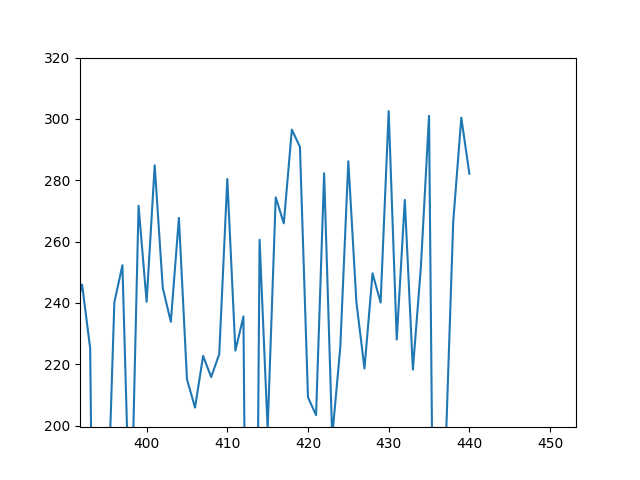

In [224]:
plt.plot(hist_s)

In [6]:
env = gym.make('LunarLander-v2')

In [198]:
class DDQN:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-3, batch_size=256, epsilon_decrease=0.01, epsilon_min=0.1):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data*0)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 100000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target = True):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = random.sample(self.memory, int(self.memory_lim*0.9))
            print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
            targets = rewards + self.gamma * (1 - dones) * (self.q_function(next_states)[np.arange(self.batch_size),torch.argmax(self.q_function_(next_states), dim=1)])
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [199]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

episode_n = 2000
t_max = 2000
do_clear = True

agent_d = DDQN(state_dim, action_dim,epsilon_decrease=0.05/episode_n)
hist_d = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_d.get_action([state])
        next_state, reward, done, _ = env.step(action[0])

        total_reward += reward
        agent_d.fit(state, int(action), reward, done, next_state,tau = 0.01)

        state = next_state

        if done:
            break
    
    hist_d.append(total_reward)
        
    if(np.mean(hist_d[-100:])>220):
        break

    print(f'episode: {episode}, total_reward_last_100: {np.mean(hist_d[-100:])} {total_reward}, epsilon: {agent_d.epsilon}')

episode: 0, total_reward_last_100: -166.88690440178692 -166.88690440178692, epsilon: 1
episode: 1, total_reward_last_100: -112.51997669864834 -58.15304899550975, epsilon: 1
episode: 2, total_reward_last_100: -132.53235483310195 -172.5571111020092, epsilon: 1
episode: 3, total_reward_last_100: -121.55694743674226 -88.63072524766316, epsilon: 0.9988249999999975
episode: 4, total_reward_last_100: -134.1343040990184 -184.443730748123, epsilon: 0.9962999999999922
episode: 5, total_reward_last_100: -128.12029613860344 -98.05025633652859, epsilon: 0.9944999999999884
episode: 6, total_reward_last_100: -166.0329604585849 -393.5089463784737, epsilon: 0.9921999999999835
episode: 7, total_reward_last_100: -147.7550160257921 -19.809404996242193, epsilon: 0.9895249999999779
episode: 8, total_reward_last_100: -145.2000972892699 -124.76074739709259, epsilon: 0.9879249999999745
episode: 9, total_reward_last_100: -153.1268115829948 -224.46724022651895, epsilon: 0.9852249999999688
episode: 10, total_rewa

episode: 80, total_reward_last_100: -151.0708535145651 -132.6822151707408, epsilon: 0.8130499999996055
episode: 81, total_reward_last_100: -150.56389813768354 -109.50051261027937, epsilon: 0.8098499999995987
episode: 82, total_reward_last_100: -150.06733719160079 -109.34933961281342, epsilon: 0.8068749999995924
episode: 83, total_reward_last_100: -151.5121902992938 -271.43499823781303, epsilon: 0.8032249999995847
episode: 84, total_reward_last_100: -150.79744218057772 -90.75860020842765, epsilon: 0.800524999999579
episode: 85, total_reward_last_100: -149.93875408048106 -76.95026557226498, epsilon: 0.7971499999995719
episode: 86, total_reward_last_100: -149.41803197164677 -104.63593061189768, epsilon: 0.7941749999995656
episode: 87, total_reward_last_100: -149.86592017211353 -188.8321936127236, epsilon: 0.7915499999995601
episode: 88, total_reward_last_100: -149.9539322008387 -157.6989907286518, epsilon: 0.7882749999995532
episode: 89, total_reward_last_100: -148.83781272552613 -49.5031

episode: 159, total_reward_last_100: -111.00279907150187 -268.41298303680355, epsilon: 0.5489249999990481
episode: 160, total_reward_last_100: -111.47325057359512 -113.98631253089788, epsilon: 0.542224999999034
episode: 161, total_reward_last_100: -110.85672465747592 -47.73220742486543, epsilon: 0.5397999999990288
episode: 162, total_reward_last_100: -112.81735024746703 -429.504636656436, epsilon: 0.5359249999990207
episode: 163, total_reward_last_100: -115.23485593043497 -333.9985742902595, epsilon: 0.5337999999990162
episode: 164, total_reward_last_100: -120.94420675672836 -605.0801232910219, epsilon: 0.5300749999990083
episode: 165, total_reward_last_100: -129.02668110899205 -997.2761914104913, epsilon: 0.5222749999989919
episode: 166, total_reward_last_100: -133.11519715752914 -508.4461833499592, epsilon: 0.5202499999989876
episode: 167, total_reward_last_100: -137.4522985794947 -537.5263510388764, epsilon: 0.5175249999989818
episode: 168, total_reward_last_100: -135.80435445787316

episode: 237, total_reward_last_100: -348.5378048156153 -202.89143875128195, epsilon: 0.19872499999897808
episode: 238, total_reward_last_100: -352.10899063273007 -500.97056185740405, epsilon: 0.19192499999897883
episode: 239, total_reward_last_100: -353.90103524761065 -241.33834812426787, epsilon: 0.18834999999897922
episode: 240, total_reward_last_100: -353.6477256216224 -96.38028460361548, epsilon: 0.18112499999898002
episode: 241, total_reward_last_100: -355.7616478463214 -256.6494828346355, epsilon: 0.17662499999898051
episode: 242, total_reward_last_100: -355.7670632173379 -83.11768471682036, epsilon: 0.17087499999898115
episode: 243, total_reward_last_100: -355.6218814136262 -227.9570134960614, epsilon: 0.1657749999989817
episode: 244, total_reward_last_100: -358.59877429215226 -399.96345156741273, epsilon: 0.15984999999898236
episode: 245, total_reward_last_100: -361.9484368381937 -378.68594071738204, epsilon: 0.15277499999898314
episode: 246, total_reward_last_100: -365.297170

episode: 315, total_reward_last_100: -122.421137744644 154.17988042757867, epsilon: 0.09999999999898895
episode: 316, total_reward_last_100: -118.24120263809964 193.91766638957952, epsilon: 0.09999999999898895
episode: 317, total_reward_last_100: -115.27645873804559 149.65269118212763, epsilon: 0.09999999999898895
episode: 318, total_reward_last_100: -113.47866646820732 -61.54904424344632, epsilon: 0.09999999999898895
episode: 319, total_reward_last_100: -110.2722191924303 -42.97288452522264, epsilon: 0.09999999999898895
episode: 320, total_reward_last_100: -111.60125347102714 -297.28410919922294, epsilon: 0.09999999999898895
episode: 321, total_reward_last_100: -107.88785867346962 164.7459229646998, epsilon: 0.09999999999898895
episode: 322, total_reward_last_100: -104.88481412779034 60.733369833211995, epsilon: 0.09999999999898895
episode: 323, total_reward_last_100: -101.11496178297979 194.36014402897837, epsilon: 0.09999999999898895
episode: 324, total_reward_last_100: -97.73749369

episode: 393, total_reward_last_100: 129.64315423291748 177.43445585636678, epsilon: 0.09999999999898895
episode: 394, total_reward_last_100: 130.7583715278339 226.1153690549482, epsilon: 0.09999999999898895
episode: 395, total_reward_last_100: 129.2095769810382 -28.365905661167275, epsilon: 0.09999999999898895
episode: 396, total_reward_last_100: 131.6494707050106 219.7850436372603, epsilon: 0.09999999999898895
episode: 397, total_reward_last_100: 132.18541734292876 209.93006340300965, epsilon: 0.09999999999898895
episode: 398, total_reward_last_100: 132.651682922068 168.0447189082645, epsilon: 0.09999999999898895
episode: 399, total_reward_last_100: 129.24176138975395 -326.65682639693694, epsilon: 0.09999999999898895
episode: 400, total_reward_last_100: 128.90207430126532 -5.983041613931022, epsilon: 0.09999999999898895
episode: 401, total_reward_last_100: 128.9764210554906 196.6380031790916, epsilon: 0.09999999999898895
episode: 402, total_reward_last_100: 130.1850307037633 182.7487

episode: 471, total_reward_last_100: 163.24792099475567 213.96744615056355, epsilon: 0.09999999999898895
episode: 472, total_reward_last_100: 163.09012501428674 211.32576907112514, epsilon: 0.09999999999898895
episode: 473, total_reward_last_100: 162.35037941297847 185.57083568502784, epsilon: 0.09999999999898895
episode: 474, total_reward_last_100: 162.70599845005475 242.42346716740087, epsilon: 0.09999999999898895
episode: 475, total_reward_last_100: 163.19992353345324 200.30354190766585, epsilon: 0.09999999999898895
episode: 476, total_reward_last_100: 163.4255145878152 255.50303029643533, epsilon: 0.09999999999898895
episode: 477, total_reward_last_100: 164.07505921514795 241.15704926302982, epsilon: 0.09999999999898895
clear memory
episode: 478, total_reward_last_100: 164.1110905018628 240.02930536583756, epsilon: 0.09999999999898895
episode: 479, total_reward_last_100: 164.16721198558068 -33.9605964975764, epsilon: 0.09999999999898895
episode: 480, total_reward_last_100: 163.9297

episode: 549, total_reward_last_100: 195.3050794051765 267.0841556854614, epsilon: 0.09999999999898895
episode: 550, total_reward_last_100: 194.98348402134746 182.78899718859714, epsilon: 0.09999999999898895
episode: 551, total_reward_last_100: 195.4775606225272 246.88712901295995, epsilon: 0.09999999999898895
episode: 552, total_reward_last_100: 195.1982242929636 190.52549271652097, epsilon: 0.09999999999898895
episode: 553, total_reward_last_100: 195.34148736319744 230.82120260912697, epsilon: 0.09999999999898895
episode: 554, total_reward_last_100: 195.7527296376811 261.395319241609, epsilon: 0.09999999999898895
episode: 555, total_reward_last_100: 195.68967563823867 230.5179932746711, epsilon: 0.09999999999898895
episode: 556, total_reward_last_100: 196.0127053398776 255.63977727443077, epsilon: 0.09999999999898895
episode: 557, total_reward_last_100: 195.7612976036709 207.7592026443441, epsilon: 0.09999999999898895
episode: 558, total_reward_last_100: 195.67939347377742 219.334822

In [223]:
#env = gym.make('LunarLander-v2')
agent_d.epsilon = 0.1
total_reward = 0
state = env.reset()
for t in range(t_max//2):
    action = agent_d.get_action([state], True)
    next_state, reward, done, _ = env.step(action[0])
    env.render()
    total_reward += reward
    state = next_state
    if done:
        break
print(total_reward)

-558.2730384799879


In [200]:
for target_param, local_param in zip(agent_d.q_function_.parameters(), agent_d.q_function.parameters()):
    print(torch.max((target_param-local_param)/target_param),torch.max((target_param-local_param)/local_param))

tensor(0.9472, grad_fn=<MaxBackward1>) tensor(17.9465, grad_fn=<MaxBackward1>)
tensor(0.2104, grad_fn=<MaxBackward1>) tensor(0.2664, grad_fn=<MaxBackward1>)
tensor(2.2514, grad_fn=<MaxBackward1>) tensor(2.0815, grad_fn=<MaxBackward1>)
tensor(0.7409, grad_fn=<MaxBackward1>) tensor(2.8591, grad_fn=<MaxBackward1>)
tensor(0.0214, grad_fn=<MaxBackward1>) tensor(0.0219, grad_fn=<MaxBackward1>)
tensor(-0.0011, grad_fn=<MaxBackward1>) tensor(-0.0011, grad_fn=<MaxBackward1>)


In [16]:
def picc(vx=0,vy=0,f=0,w=0,l=0,r=0):
    pic = np.zeros((300,300,3))
    pic_w = np.zeros((300,300,3))
    obs = np.zeros((300*300,8))
    for x in range(300):
        for y in range(300):
            obs[x*300+y] = np.array([-1.5+x/100,1.5-y/100,vx,vy,f,w,l,r])
    act_flat = agent.get_action(obs)
    actions = np.zeros((300,300),dtype=np.int32)
    for x in range(300):
        for y in range(300):
            actions[x,y] = act_flat[x*300+y]
            
    max_actions = actions
    for x in range(300):
        for y in range(300):
            if max_actions[x,y]>0:
                pic[x,y,max_actions[x,y]-1] = 1
                
    fig = plt.figure(figsize=(5,10))
    ax = plt.subplot(211)
    ax.imshow(pic_w)
    rect = patches.Rectangle((150-20, 150-15), 40, 30, angle=-f/3.14*180, linewidth=1, edgecolor='b', facecolor='b')
    arrow = patches.Arrow(150, 150,vx*100,-vy*100, width=10,  edgecolor='red', facecolor='r')
    ax.add_patch(rect)
    ax.add_patch(arrow)
    plt.subplot(212)
    plt.imshow(pic.transpose(1,0,2))
    plt.savefig(f'visual/lunalender_vx{vx}_vy{vy}_f{f}.png',dpi=300, bbox_inches='tight',facecolor='white')

<IPython.core.display.Javascript object>


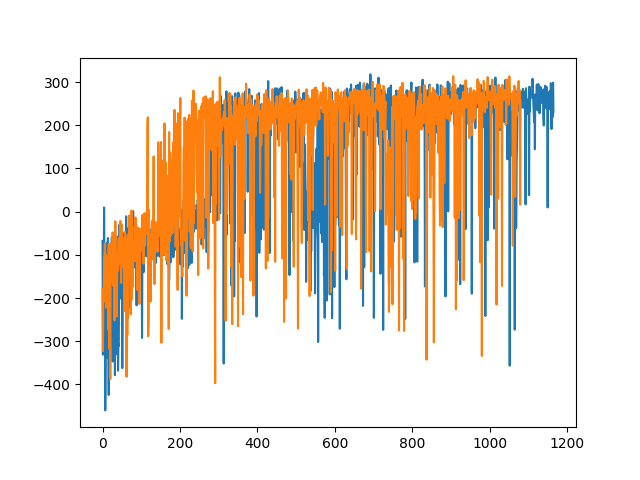

In [12]:
plt.plot(hist_s)
plt.plot(hist_d)

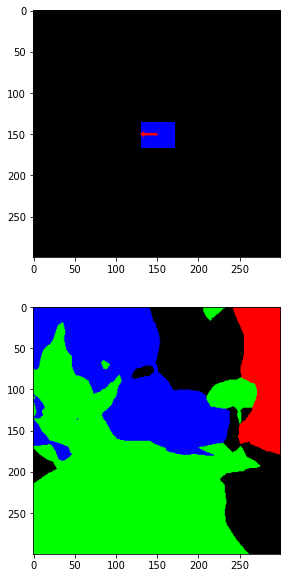

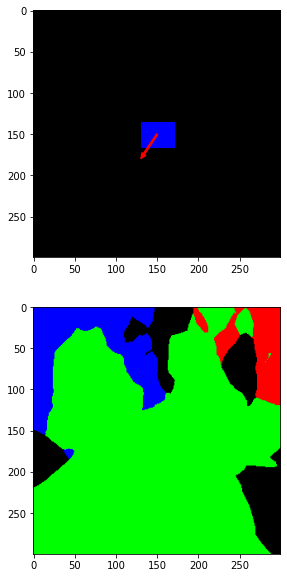

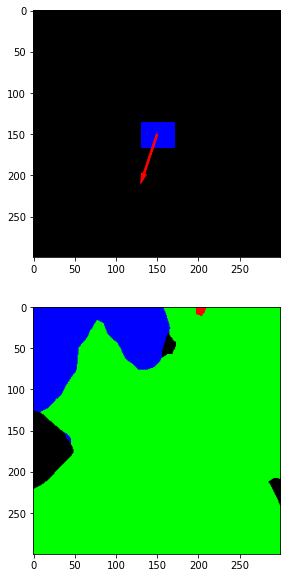

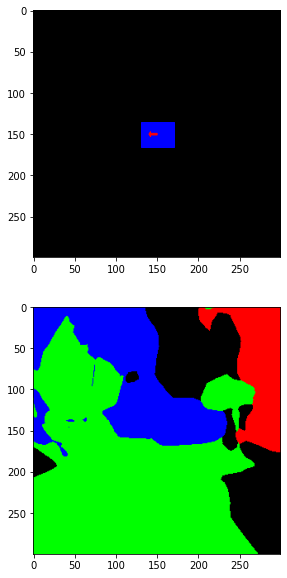

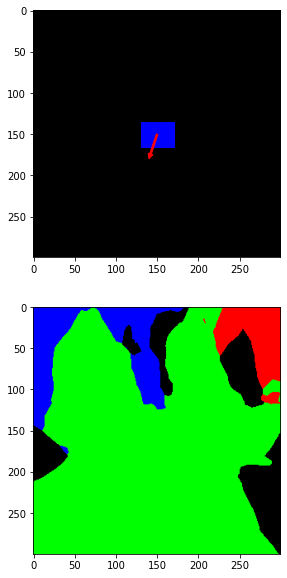

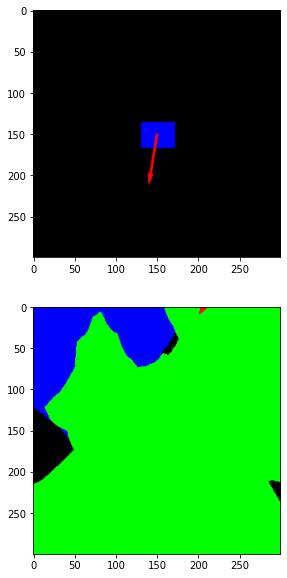

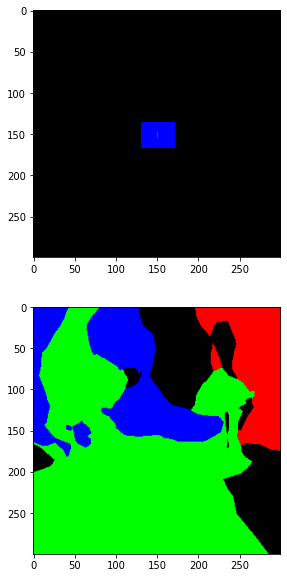

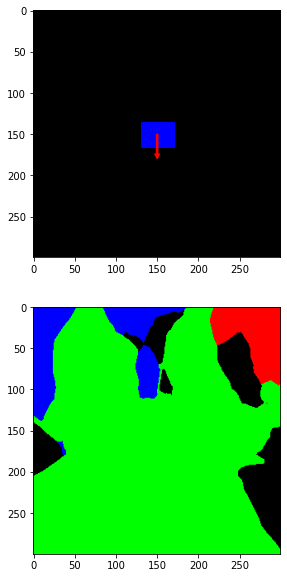

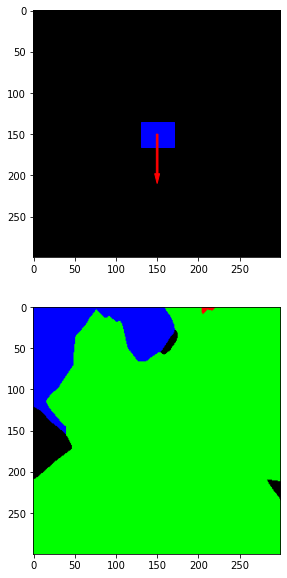

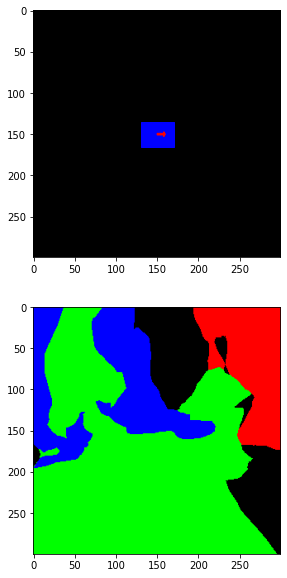

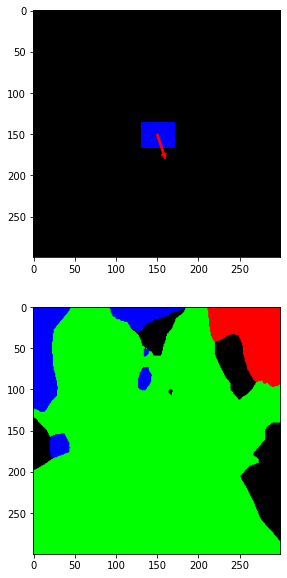

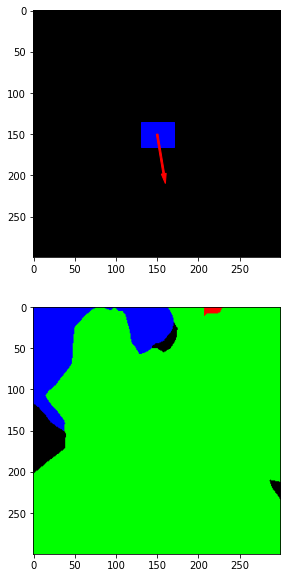

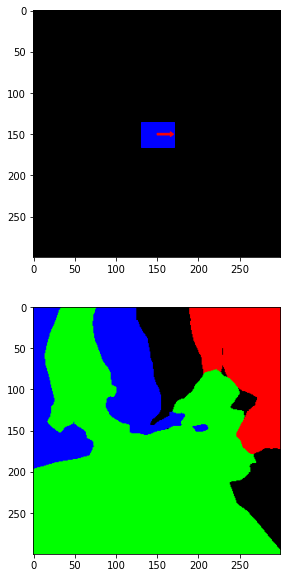

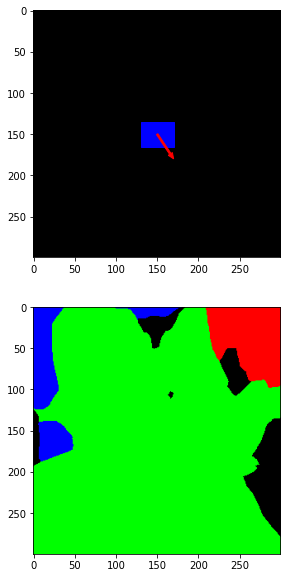

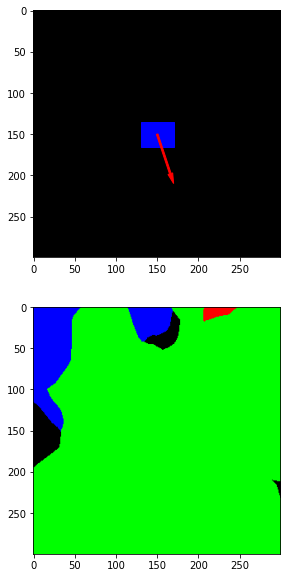

In [17]:
vx = [-0.2, -0.1, 0, 0.1 , 0.2]
vy = [0, -0.3, -0.6]
f = [0]
for i in range(5):
    for j in range(3):
        for k in range(1):
            picc(vx[i],vy[j],f[k])